Project description
===
```
Here we have a dataset of hypotheses for A/B testing, visits, and orders of an online store. We want to test them to find what can boost our revenue.

First, we should do some data preprocessing: clean the data and change data types. After doing so, we could analyze our data.
```

**Description of the data**
```
/datasets/hypotheses_us.csv
    Hypotheses — brief descriptions of the hypotheses
    Reach — user reach, on a scale of one to ten
    Impact — impact on users, on a scale of one to ten
    Confidence — confidence in the hypothesis, on a scale of one to ten
    Effort — the resources required to test a hypothesis, on a scale of one to ten

/datasets/orders_us.csv
    transactionId — order identifier
    visitorId — identifier of the user who placed the order
    date — of the order
    revenue — from the order
    group — the A/B test group that the user belongs to
    
/datasets/visits_us.csv
    date — date
    group — A/B test group
    visits — the number of visits on the date specified in the A/B test group specified
```

## Open the data and study the general information

In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [2]:
import math
import matplotlib.pyplot as plt 
from matplotlib.ticker import PercentFormatter
import numpy as np
import pandas as pd
from scipy import stats 
import seaborn as sns
from statsmodels.stats.proportion import proportions_ztest
from IPython.display import HTML, display_html
from IPython.core.interactiveshell import InteractiveShell

In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
%config InlineBackend.figure_format = 'retina'
InteractiveShell.ast_node_interactivity = 'all'
pd.set_option('display.float_format', '{:.3f}'.format)
pd.set_option('display.max_colwidth', None) # no wrap
pd.set_option('display.max_columns', 500) # columns number

In [4]:
orders_dtype = {'transactionId': 'uint32', 'visitorId': 'uint32', 'revenue': 'float32', 'group': 'category'}
orders_dates = ['date']

visits_dtype = {'group': 'category', 'visits': 'uint16'}
visits_dates = ['date']


try:
    hypotheses = pd.read_csv('./datasets/hypotheses_us.csv', sep=';')
    orders = pd.read_csv('./datasets/orders_us.csv', dtype=orders_dtype, parse_dates=orders_dates)
    visits = pd.read_csv('./datasets/visits_us.csv', dtype=visits_dtype, parse_dates=visits_dates)
except:
    hypotheses = pd.read_csv('../datasets/hypotheses_us.csv', sep=';')
    orders = pd.read_csv('../datasets/orders_us.csv', dtype=orders_dtype, parse_dates=orders_dates) 
    visits = pd.read_csv('../datasets/visits_us.csv', dtype=visits_dtype, parse_dates=visits_dates) 

In [5]:
hypotheses.columns = hypotheses.columns.str.lower().str.replace(' ', '_')
hypotheses.info()
hypotheses
print('Duplicates in data: {0}'.format(hypotheses.duplicated().sum()))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   hypothesis  9 non-null      object
 1   reach       9 non-null      int64 
 2   impact      9 non-null      int64 
 3   confidence  9 non-null      int64 
 4   effort      9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


,hypothesis,reach,impact,confidence,effort
0,Add two new channels for attracting traffic. This will bring 30% more users,3,10,8,6
1,Launch your own delivery service. This will shorten delivery time,2,5,4,10
2,Add product recommendation blocks to the store's site. This will increase conversion and average purchase size,8,3,7,3
3,Change the category structure. This will increase conversion since users will find the products they want more quickly,8,3,3,8
4,Change the background color on the main page. This will increase user engagement,3,1,1,1
5,Add a customer review page. This will increase the number of orders,3,2,2,3
6,Show banners with current offers and sales on the main page. This will boost conversion,5,3,8,3
7,Add a subscription form to all the main pages. This will help you compile a mailing list,10,7,8,5
8,Launch a promotion that gives users discounts on their birthdays,1,9,9,5


Duplicates in data: 0


In `hypotheses` there are no missing values or duplicates. 

---

In [6]:
orders.columns = orders.columns.str.lower().str.replace(' ', '_')
orders.info()
orders.describe()
orders.sample(5)
print('Duplicates in data: {0}'.format(orders.duplicated().sum()))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   transactionid  1197 non-null   uint32        
 1   visitorid      1197 non-null   uint32        
 2   date           1197 non-null   datetime64[ns]
 3   revenue        1197 non-null   float32       
 4   group          1197 non-null   category      
dtypes: category(1), datetime64[ns](1), float32(1), uint32(2)
memory usage: 24.8 KB


,transactionid,visitorid,revenue
count,1197.000,1197.000,1197.000
mean,2155621385.530,2165960143.099,131.492
std,1229084904.760,1236014192.147,603.005
min,1062393.000,5114589.000,5.000
25%,1166775572.000,1111826046.000,20.800
50%,2145193898.000,2217984702.000,50.200
75%,3237740112.000,3177606451.000,130.400
max,4293855558.000,4283872382.000,19920.400


,transactionid,visitorid,date,revenue,group
195,2872509092,983496389,2019-08-02,5.500,A
82,1246801103,2096506107,2019-08-16,80.500,B
970,3478707774,2587333274,2019-08-08,60.400,A
669,165288431,2162698752,2019-08-29,265.400,A
559,2888367978,1052142804,2019-08-06,15.700,A


Duplicates in data: 0


In `orders` there are no missing values or duplicates. The `transactionid` and `visitorid` columns were read as uint32, `data` as datetime, `revenue` as float32, and `group` as category,

---

In [7]:
visits.columns = visits.columns.str.lower().str.replace(' ', '_')
visits.info()
visits.describe()
visits.sample(5)
print('Duplicates in data: {0}'.format(visits.duplicated().sum()))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    62 non-null     datetime64[ns]
 1   group   62 non-null     category      
 2   visits  62 non-null     uint16        
dtypes: category(1), datetime64[ns](1), uint16(1)
memory usage: 826.0 bytes


,visits
count,62.000
mean,607.290
std,114.401
min,361.000
25%,534.000
50%,624.500
75%,710.500
max,770.000


,date,group,visits
6,2019-08-07,A,644
16,2019-08-17,A,412
35,2019-08-05,B,707
50,2019-08-20,B,560
23,2019-08-24,A,395


Duplicates in data: 0


In `visits` there are no missing values or duplicates. The `data` column was read as datetime, `group` as category, and `revenue` as uint16.

---

**Conclusion**

There are no missing values in this dataset.

After the first investigation, we changed data types to categories and datetimes and downcasted floats and unsigned while reading from the file.  

We don't have any duplicates in this data set, so there is nothing to drop here.

## Data preprocessing

In [8]:
badvisitors = orders.groupby(['visitorid'], as_index=False).agg({'group': 'nunique'})
badvisitors = badvisitors[badvisitors['group']>1]
orders = orders[~orders['visitorid'].isin(badvisitors['visitorid'])]

**Conclusion**

In `orders`, we had 58 `visitorid`s belonging to both groups. Unfortunately, we can't know to which group these visitors were assigned, so it's better to drop these 181 orders.

## Analyze the data

### Prioritizing Hypotheses

#### Apply the ICE framework to prioritize hypotheses. Sort them in descending order of priority.

In [9]:
hypotheses['ICE'] = hypotheses['impact'] * hypotheses['confidence'] / hypotheses['effort']
hypotheses[['hypothesis','ICE']].sort_values(by='ICE', ascending=False).style.format(precision=2)

,hypothesis,ICE
8,Launch a promotion that gives users discounts on their birthdays,16.20
0,Add two new channels for attracting traffic. This will bring 30% more users,13.33
7,Add a subscription form to all the main pages. This will help you compile a mailing list,11.20
6,Show banners with current offers and sales on the main page. This will boost conversion,8.00
2,Add product recommendation blocks to the store's site. This will increase conversion and average purchase size,7.00
1,Launch your own delivery service. This will shorten delivery time,2.00
5,Add a customer review page. This will increase the number of orders,1.33
3,Change the category structure. This will increase conversion since users will find the products they want more quickly,1.12
4,Change the background color on the main page. This will increase user engagement,1.00


---
#### Apply the RICE framework to prioritize hypotheses. Sort them in descending order of priority.

In [10]:
hypotheses['RICE'] = hypotheses['reach'] *  hypotheses['impact'] * hypotheses['confidence'] / hypotheses['effort']
hypotheses[['hypothesis','RICE']].sort_values(by='RICE', ascending=False).style.format(precision=2)

,hypothesis,RICE
7,Add a subscription form to all the main pages. This will help you compile a mailing list,112.00
2,Add product recommendation blocks to the store's site. This will increase conversion and average purchase size,56.00
0,Add two new channels for attracting traffic. This will bring 30% more users,40.00
6,Show banners with current offers and sales on the main page. This will boost conversion,40.00
8,Launch a promotion that gives users discounts on their birthdays,16.20
3,Change the category structure. This will increase conversion since users will find the products they want more quickly,9.00
1,Launch your own delivery service. This will shorten delivery time,4.00
5,Add a customer review page. This will increase the number of orders,4.00
4,Change the background color on the main page. This will increase user engagement,3.00


**Conclusion**

Applying the RICE framework (instead of ICE) to prioritize hypotheses moved hypotheses number seven and two from the middle of the list to the top.  The more significant reach factors help to boost hypotheses.

---

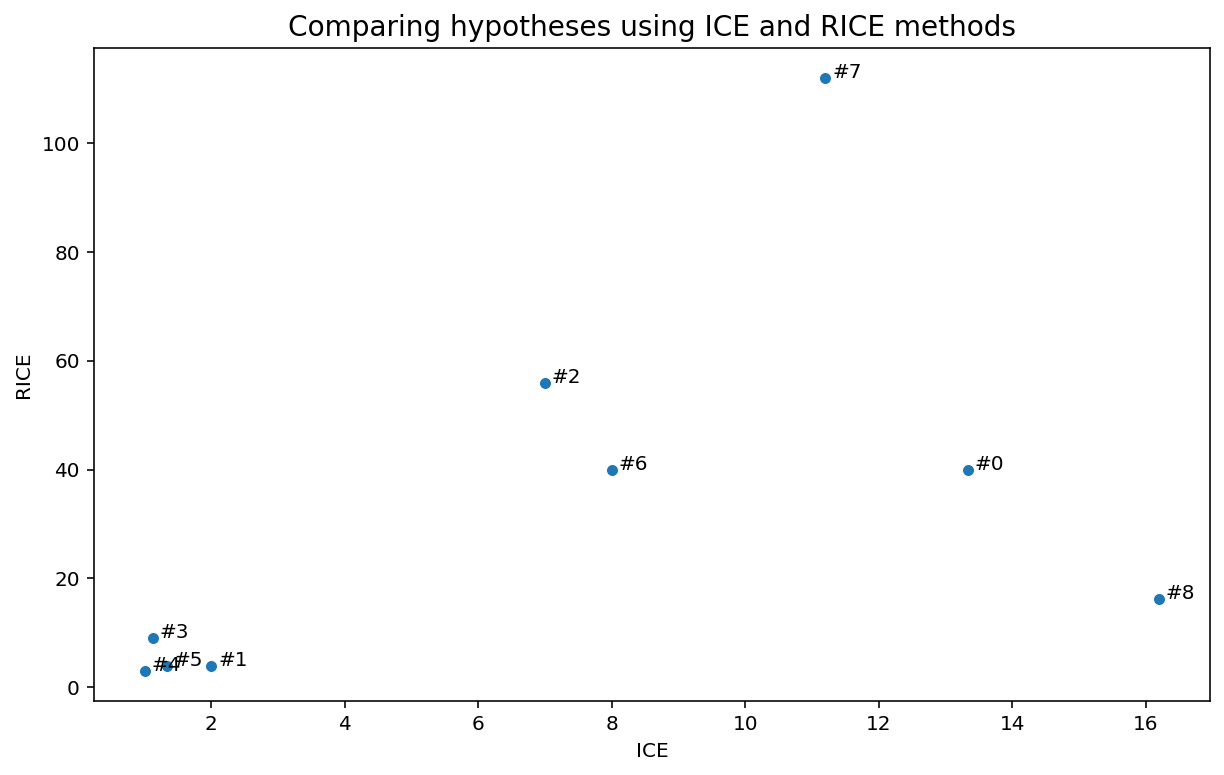

In [11]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=hypotheses['ICE'], y=hypotheses['RICE'])
for i in range(0, hypotheses.shape[0]):
    plt.text(hypotheses.ICE[i]+0.1, hypotheses.RICE[i], 
              '#{:0.0f}'.format(hypotheses.index[i]), 
              horizontalalignment='left', size='medium', color='black')
plt.title('Comparing hypotheses using ICE and RICE methods', size=14)
plt.show();

### A/B Test Analysis

In [12]:
groupA = orders[orders['group']=='A'].groupby(['date'], as_index=False).\
                agg({'transactionid':'nunique', 'visitorid': 'nunique', 'revenue': 'sum'}).\
                rename(columns={'transactionid':'orders', 'visitorid':'buyers'}).\
                merge(visits[visits['group']=='A'][['date','visits']], on='date')

groupB = orders[orders['group']=='B'].groupby(['date'], as_index=False).\
                agg({'transactionid':'nunique', 'visitorid': 'nunique', 'revenue': 'sum'}).\
                rename(columns={'transactionid':'orders', 'visitorid':'buyers'}).\
                merge(visits[visits['group']=='B'][['date','visits']], on='date')

#### Graph cumulative revenue by group.

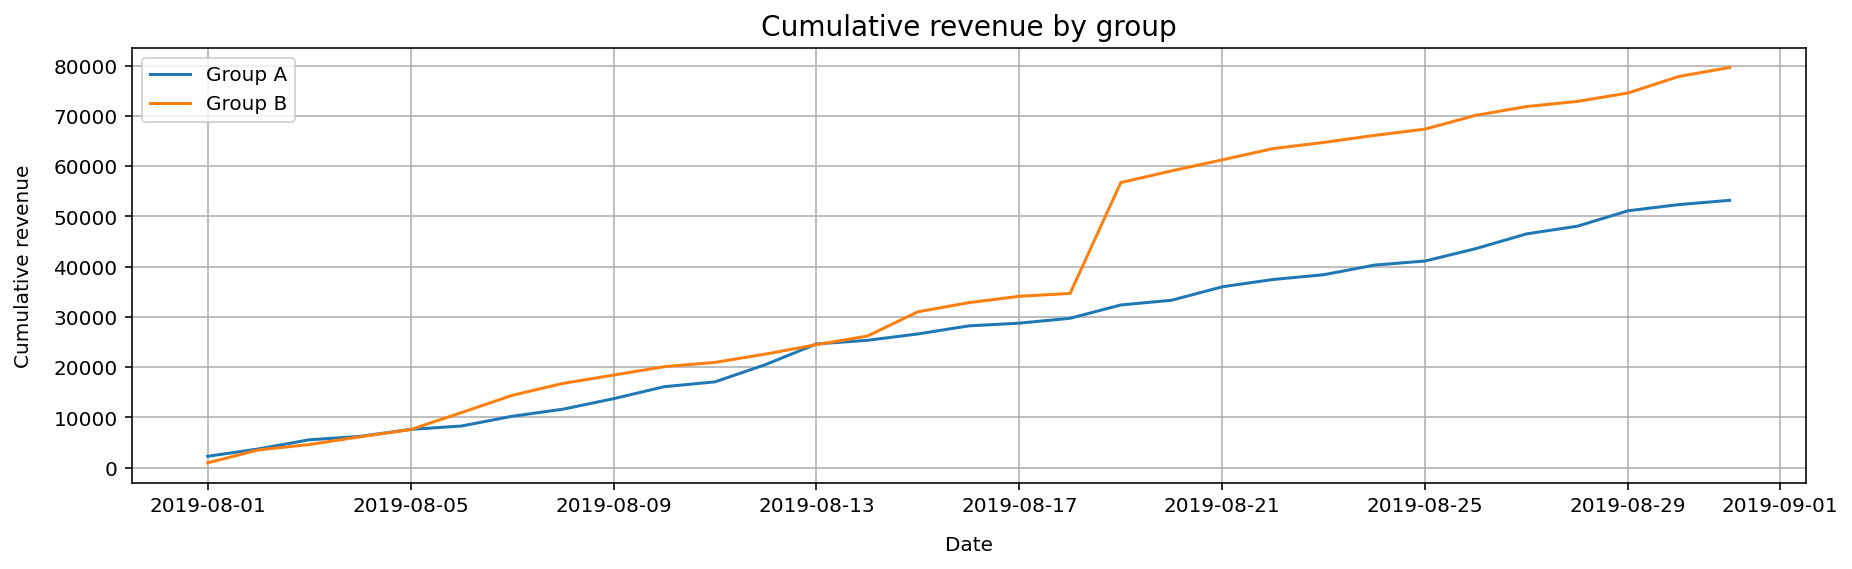

In [13]:
groupA['cum_rev'] = groupA['revenue'].cumsum()
groupB['cum_rev'] = groupB['revenue'].cumsum()

fig, ax = plt.subplots(figsize=(15, 4))
sns.lineplot(data=groupA, x='date', y='cum_rev', linewidth=1.5, ax=ax, label='Group A')
sns.lineplot(data=groupB, x='date', y='cum_rev', linewidth=1.5, ax=ax, label='Group B')

ax.set_title('Cumulative revenue by group', fontsize=14)
ax.set_xlabel('Date', labelpad=10)
ax.set_ylabel('Cumulative revenue', labelpad=10)
plt.grid()
plt.legend();

**Conclusion**

After stabilizing, the cumulative revenue of Group B is consistently higher than that of Group A. Also, here we see a sudden rise for Group B, which could be due to massive orders.

----
#### Graph cumulative average order size by group.

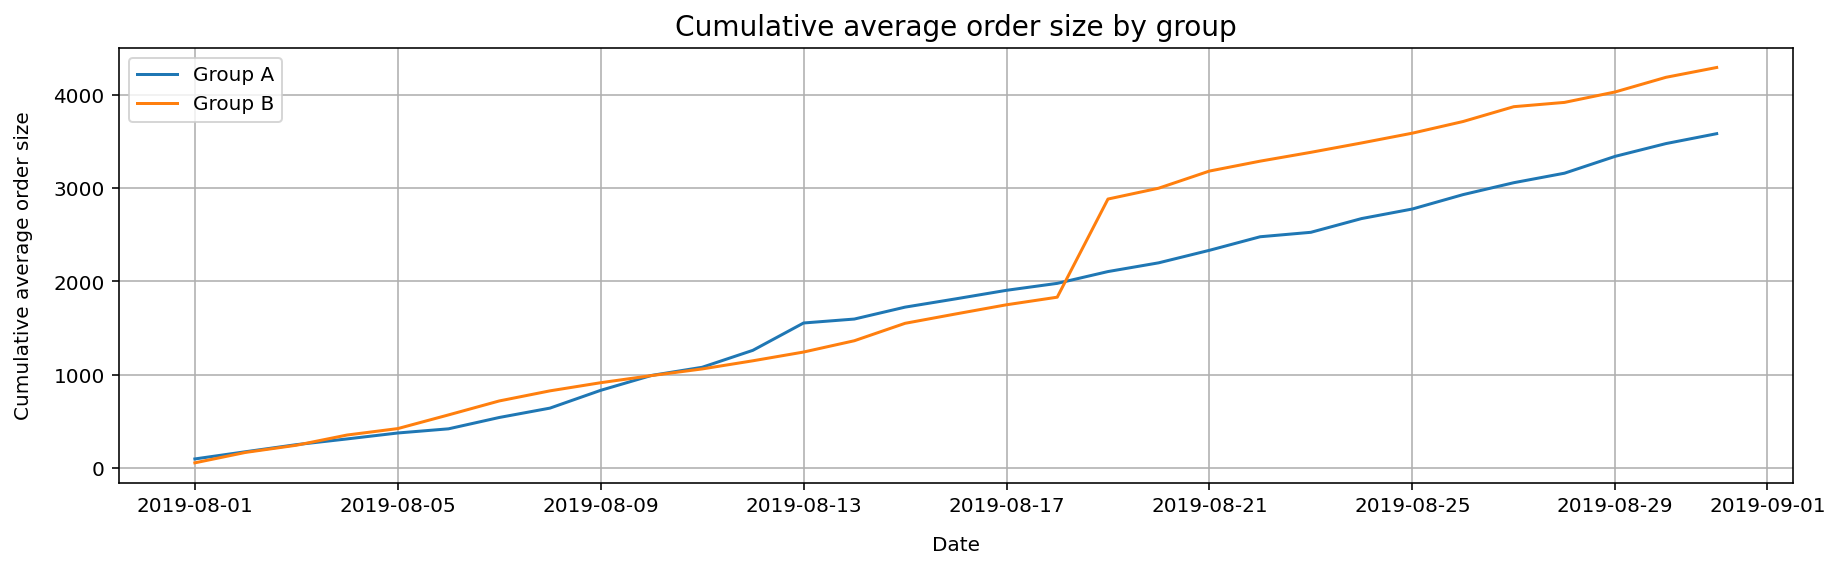

In [14]:
groupA['avr_order'] = groupA['revenue'] / groupA['orders']
groupB['avr_order'] = groupB['revenue'] / groupB['orders']

groupA['cum_avg_order'] = groupA['avr_order'].cumsum()
groupB['cum_avg_order'] = groupB['avr_order'].cumsum()


fig, ax = plt.subplots(figsize=(15, 4))
sns.lineplot(data=groupA, x='date', y='cum_avg_order', linewidth=1.5, ax=ax, label='Group A')
sns.lineplot(data=groupB, x='date', y='cum_avg_order', linewidth=1.5, ax=ax, label='Group B')

ax.set_title('Cumulative average order size by group', fontsize=14)
ax.set_xlabel('Date', labelpad=10)
ax.set_ylabel('Cumulative average order size', labelpad=10)
plt.grid()
plt.legend();

**Conclusion**

After stabilizing, Group B's cumulative average order size is consistently higher than that of Group A. Here we too see a sudden rise for Group B, which could be due to massive orders.

----
#### Graph the relative difference in cumulative average order size for group B compared with group A.

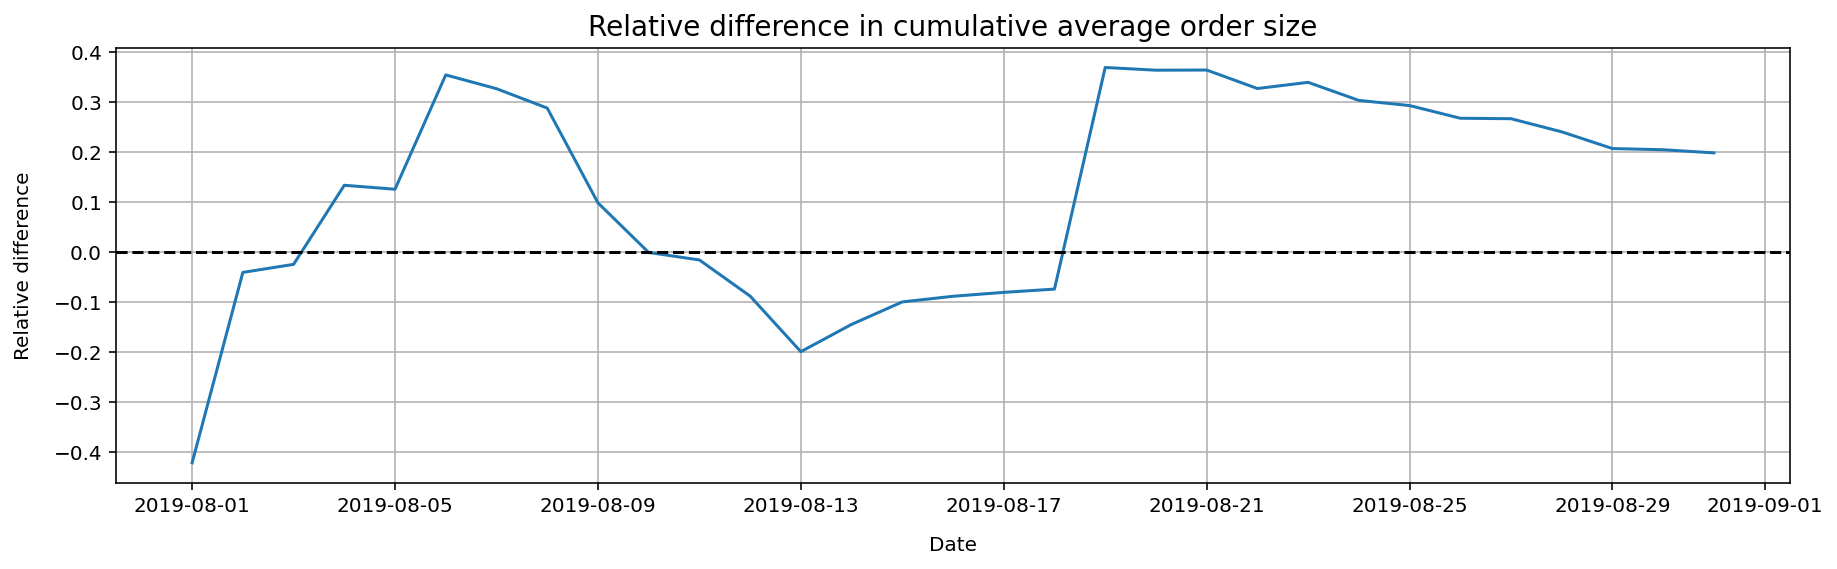

In [15]:
merged = groupA[['date','cum_avg_order']].merge(groupB[['date','cum_avg_order']], \
                                                on='date', how='left', suffixes=['_A', '_B'])
merged['relative_avg_order'] = merged['cum_avg_order_B'] / merged['cum_avg_order_A']-1


fig, ax = plt.subplots(figsize=(15, 4))
sns.lineplot(data=merged, x='date', y='relative_avg_order', linewidth=1.5, ax=ax)
plt.axhline(y=0, color='black', linestyle='--')

ax.set_title('Relative difference in cumulative average order size', fontsize=14)
ax.set_xlabel('Date', labelpad=10)
ax.set_ylabel('Relative difference', labelpad=10)
plt.grid();

**Conclusion**

The relative difference in cumulative average order size shows us some spikes. It could be due to outliers.

----
#### Calculate each group's conversion rate as the ratio of orders to the number of visits for each day. Plot the daily conversion rates of the two groups and describe the difference. 

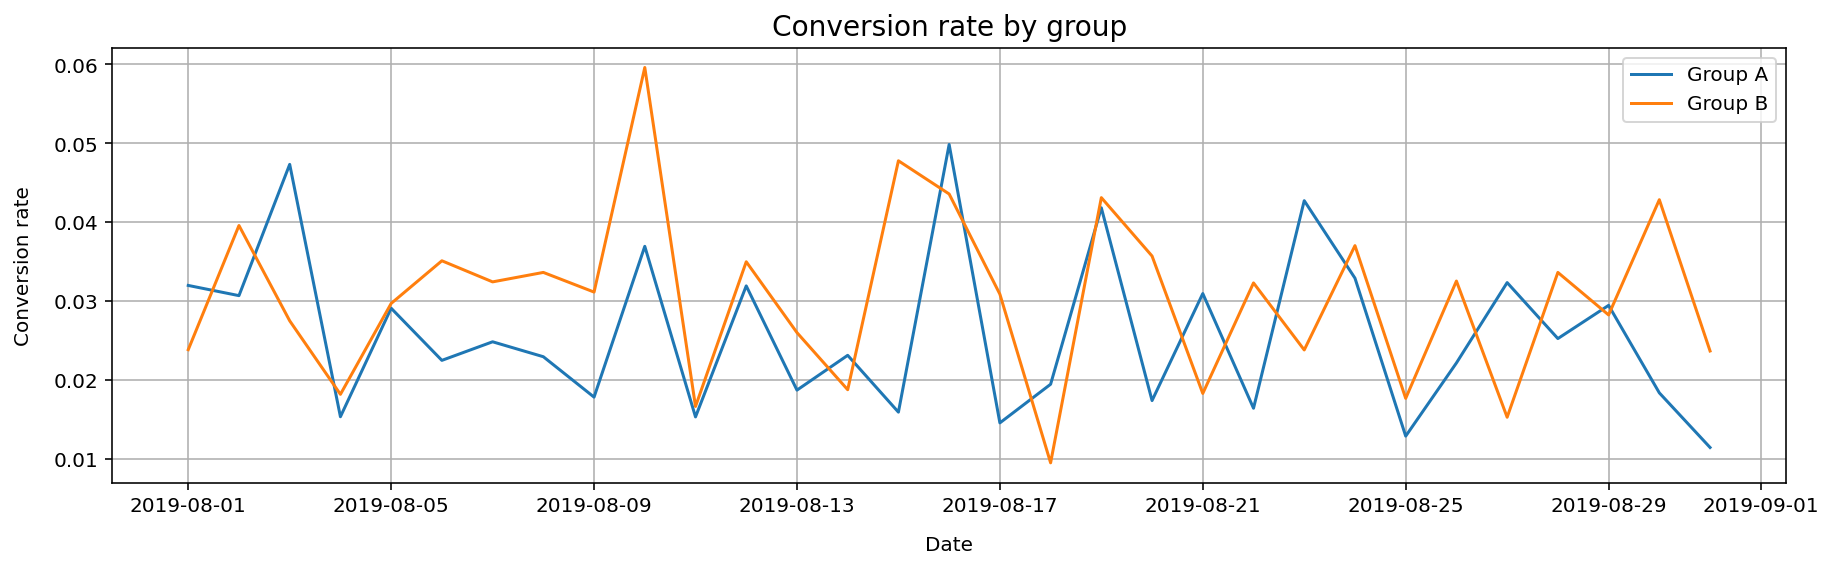

In [16]:
groupA['conversion'] = groupA['orders'] / groupA['visits']
groupB['conversion'] = groupB['orders'] / groupB['visits']

fig, ax = plt.subplots(figsize=(15, 4))
sns.lineplot(data=groupA, x='date', y='conversion', linewidth=1.5, ax=ax, label='Group A')
sns.lineplot(data=groupB, x='date', y='conversion', linewidth=1.5, ax=ax, label='Group B')

ax.set_title('Conversion rate by group', fontsize=14)
ax.set_xlabel('Date', labelpad=10)
ax.set_ylabel('Conversion rate', labelpad=10)
plt.grid()
plt.legend();

In [17]:
print('Overall conversion of group A: {:.3f}'.format(groupA['orders'].sum()/groupA['visits'].sum()))
print('Overall conversion of group B: {:.3f}'.format(groupB['orders'].sum()/groupB['visits'].sum()))

Overall conversion of group A: 0.025
Overall conversion of group B: 0.029


**Conclusion**

The overall conversion rate of Group B is higher, but the daily conversion rates of both groups fluctuate between 1% and 6%. 

----
#### Graph the relative difference in conversion rates for group B compared with group A.

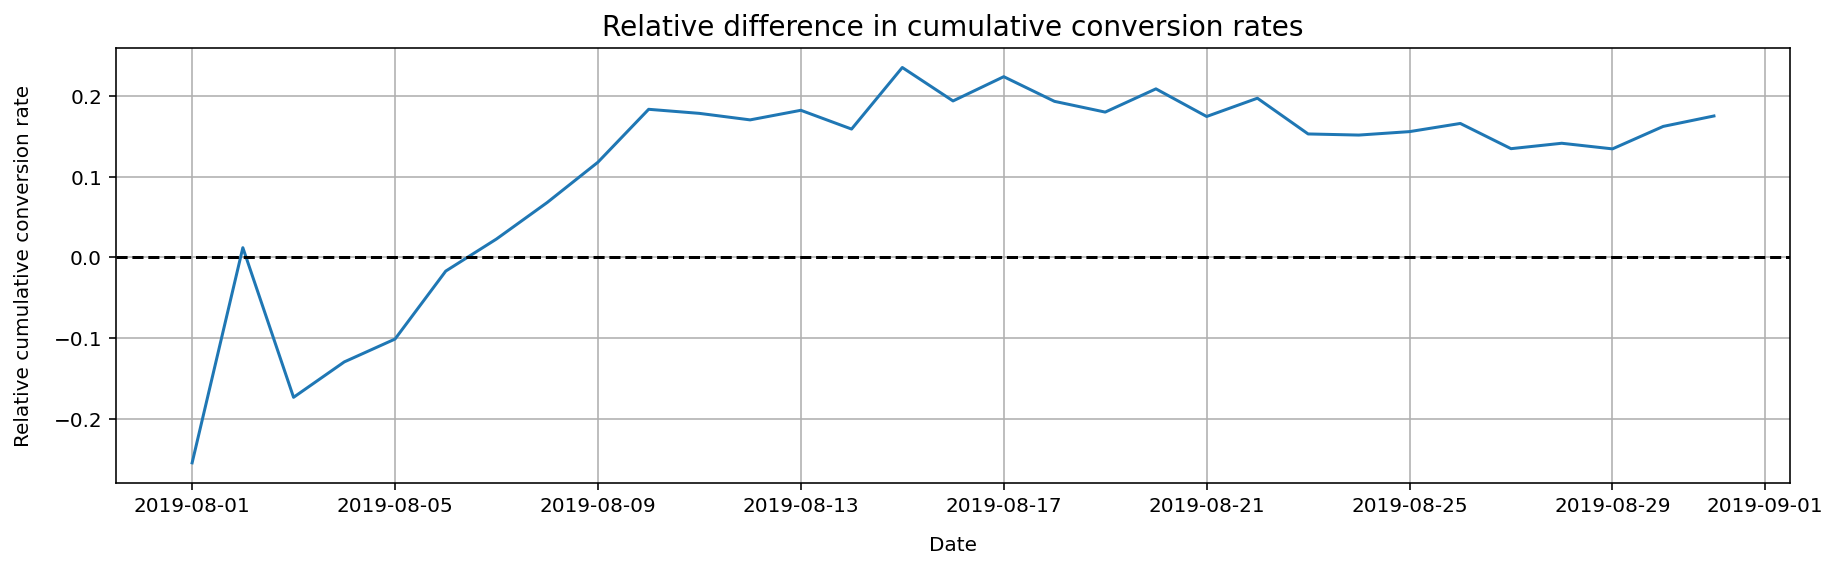

In [18]:
groupA['cum_conversion'] = groupA['conversion'].cumsum()
groupB['cum_conversion'] = groupB['conversion'].cumsum()

merged2 = groupA[['date','cum_conversion']].merge(groupB[['date','cum_conversion']], \
                                                on='date', how='left', suffixes=['_A', '_B'])
merged2['relative_cum_conversion'] = merged2['cum_conversion_B'] / merged2['cum_conversion_A']-1


fig, ax = plt.subplots(figsize=(15, 4))
sns.lineplot(data=merged2, x='date', y='relative_cum_conversion', linewidth=1.5, ax=ax)
plt.axhline(y=0, color='black', linestyle='--')

ax.set_title('Relative difference in cumulative conversion rates', fontsize=14)
ax.set_xlabel('Date', labelpad=10)
ax.set_ylabel('Relative cumulative conversion rate', labelpad=10)
plt.grid();

**Conclusion**

The relative difference in cumulative conversion stabilizes earlier than the cumulative average order size. It looks like Group B is doing better.

----
#### Plot a scatter chart of the number of orders per user.

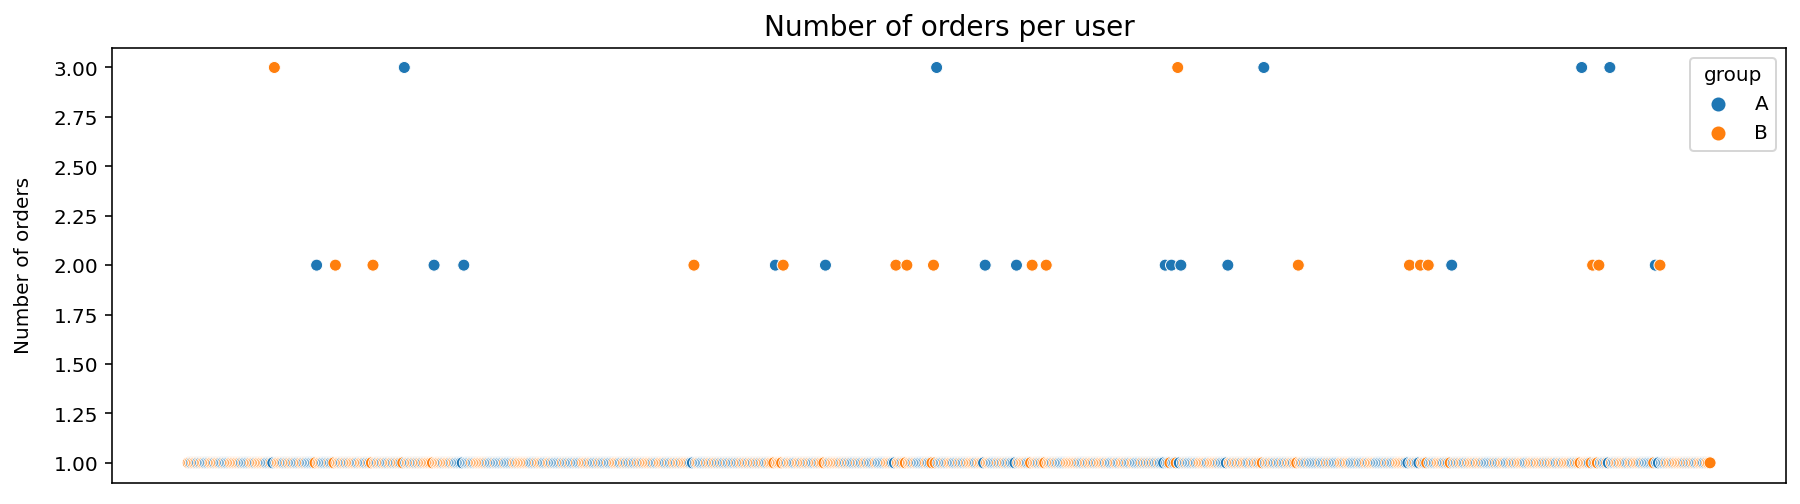

In [19]:
orders_by_user = orders.groupby('visitorid', as_index=False).agg({'group':'first', 'transactionid': 'nunique'})\
                .rename(columns={'transactionid':'orders',}).reset_index()

fig, ax = plt.subplots(figsize=(15, 4))
sns.scatterplot(data=orders_by_user, x='index', y='orders', hue='group', ax=ax);
ax.set_title('Number of orders per user', fontsize=14)
ax.set_xlabel('', labelpad=10)
ax.xaxis.set_ticks([])
ax.set_ylabel('Number of orders', labelpad=10);

**Conclusion**

Across both groups, most users made only one order, but some made two or three. 

----
#### Calculate the 95th and 99th percentiles for the number of orders per user. Define the point at which a data point becomes an anomaly.

In [20]:
print('95th percentile for the number of orders per user:', np.percentile(orders_by_user['orders'], 95)) 
print('99th percentile for the number of orders per user:', np.percentile(orders_by_user['orders'], 99)) 

95th percentile for the number of orders per user: 1.0
99th percentile for the number of orders per user: 2.0


**Conclusion**

Counting the percentiles, we can prove that 95% of users made only one order, and 99% one or two. We could use these values to cut out the outliers.

----
#### Plot a scatter chart of order prices.

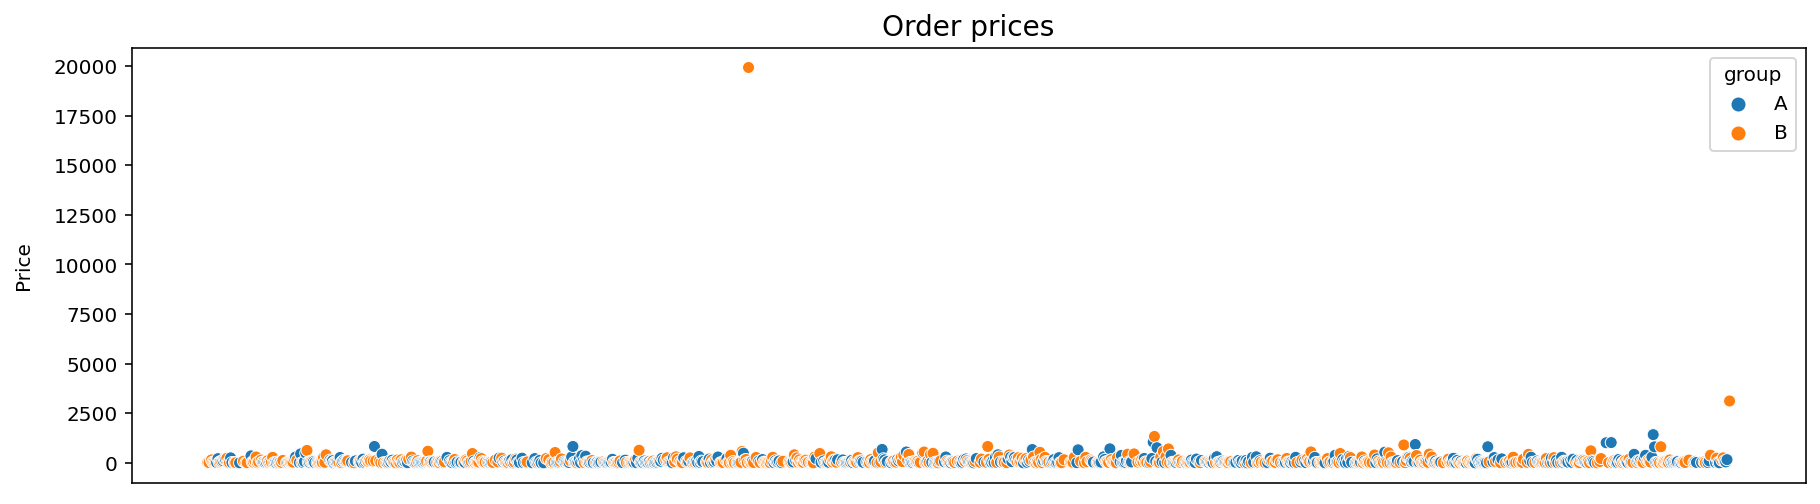

In [21]:
fig, ax = plt.subplots(figsize=(15, 4))
sns.scatterplot(data=orders.reset_index(), x='index', y='revenue', hue='group', ax=ax);
ax.set_title('Order prices', fontsize=14)
ax.set_xlabel('', labelpad=10)
ax.xaxis.set_ticks([])
ax.set_ylabel('Price', labelpad=10);

**Conclusion**

Most of the order sizes are small, but we have some outliers.  
One of them is in group B and is enormous. It could explain the sudden rise in cumulative revenue we saw earlier.

----
#### Calculate the 95th and 99th percentiles of order prices. Define the point at which a data point becomes an anomaly.

In [22]:
print('95th percentile for the order price: {:.3f}'.format(np.percentile(orders['revenue'], 95))) 
print('99th percentile for the order price: {:.3f}'.format(np.percentile(orders['revenue'], 99))) 

95th percentile for the order price: 414.275
99th percentile for the order price: 830.300


**Conclusion**

95% of orders are no more than 414 and 99% no more than 830. We could use these values to cut out the outliers.

---
So using the values from the above, we could filter out orders made by users who made more than one, and 5% the most expensive.

In [23]:
anomaly_visitors = orders_by_user[orders_by_user['orders']!=1]['visitorid']
anomaly_revenue = np.percentile(orders['revenue'], 95)

orders_new = orders[(~orders['visitorid'].isin(anomaly_visitors)) & (orders['revenue']<=anomaly_revenue)]

groupA_new = orders_new[orders_new['group']=='A'].groupby(['date'], as_index=False).\
                agg({'transactionid':'nunique', 'visitorid': 'nunique', 'revenue': 'sum'}).\
                rename(columns={'transactionid':'orders', 'visitorid':'buyers'}).\
                merge(visits[visits['group']=='A'][['date','visits']], on='date')

groupB_new = orders_new[orders_new['group']=='B'].groupby(['date'], as_index=False).\
                agg({'transactionid':'nunique', 'visitorid': 'nunique', 'revenue': 'sum'}).\
                rename(columns={'transactionid':'orders', 'visitorid':'buyers'}).\
                merge(visits[visits['group']=='B'][['date','visits']], on='date')

groupA_new['avr_order'] = groupA_new['revenue'] / groupA_new['orders']
groupB_new['avr_order'] = groupB_new['revenue'] / groupB_new['orders']
groupA_new['conversion'] = groupA_new['orders'] / groupA_new['visits']
groupB_new['conversion'] = groupB_new['orders'] / groupB_new['visits']

In [24]:
def testing_proportion(successes1, trials1, successes2, trials2, alpha=0.05):
    statist, p_value = proportions_ztest([successes1, successes2], [trials1, trials2])
    print('P-value: {0:0.3f}'.format(p_value))
    if p_value < alpha:
        print('Reject H0')
    else:
        print('Fail to Reject H0')
        
def testing_average(sample1, sample2, alpha=0.05):
    sample1 = sample1.dropna()
    sample2 = sample2.dropna()
    stat1, p1_norm = stats.shapiro(sample1)
    stat2, p2_norm = stats.shapiro(sample2)
    if p1_norm > alpha and p2_norm > alpha: # if both normal – t-test
        statslev, p_levene = stats.levene(sample1, sample2)
        if p_levene < alpha: #variances are not equal
            statist, p_value = stats.ttest_ind(sample1, sample2, equal_var=False)
        else:
            statist, p_value = stats.ttest_ind(sample1, sample2, equal_var=True) 
    else:
        statist, p_value = stats.mannwhitneyu(sample1, sample2)
    print('P-value: {0:0.3f}'.format(p_value))
    if p_value < alpha:
        print('Reject H0')
    else:
        print('Fail to Reject H0')        

alpha=0.05        

95% statistical significance level (alpha 0.05) would be enough for our tests.

----
#### Find the statistical significance of the difference in conversion between the groups using the raw data. 

*Null hypothesis:* There are no statistically significant differences in conversion between the groups.  
*Alternative hypothesis:* There is a statistically significant difference in conversion between the groups.

In [25]:
groupA_trials = groupA['visits'].sum()
groupA_successes = groupA['orders'].sum()
print('Trials Group A:', groupA_trials)
print('Successes Group A:', groupA_successes)
print('Proportion Group A: {0:0.3f}'.format(groupA_trials/groupA_successes))
print()

groupB_trials = groupB['visits'].sum()
groupB_successes = groupB['orders'].sum()
print('Trials Group B:', groupB_trials)
print('Successes Group B:', groupB_successes)
print('Proportion Group B: {0:0.3f}'.format(groupB_trials/groupB_successes))
print()

testing_proportion(groupA_successes, groupA_trials, groupB_successes, groupB_trials, alpha=alpha)

Trials Group A: 18736
Successes Group A: 468
Proportion Group A: 40.034

Trials Group B: 18916
Successes Group B: 548
Proportion Group B: 34.518

P-value: 0.017
Reject H0


In [26]:
print('Average daily conversion Group A: {0:0.3f}'.format(groupA['conversion'].mean()))
print()
print('Average daily conversion Group B: {0:0.3f}'.format(groupB['conversion'].mean()))
print()

testing_average(groupA['conversion'], groupB['conversion'], alpha=alpha)

Average daily conversion Group A: 0.026

Average daily conversion Group B: 0.030

P-value: 0.096
Fail to Reject H0


**Conclusion**

We rejected the null hypothesis by testing the overall conversion as a proportion of orders to visits. There is a statistical significance of the difference between the groups.  
But with the daily conversion, we failed to reject the null hypothesis. There is no statistical significance of the difference between the groups.

----
#### Find the statistical significance of the difference in average order size between the groups using the raw data. 

*Null hypothesis:* There are no statistically significant differences in average order size between the groups.  
*Alternative hypothesis:* There is a statistically significant difference in average order size between the groups.

In [27]:
print('Average order size Group A: {0:0.3f}'.format(groupA['avr_order'].mean()))
print()
print('Average order size Group B: {0:0.3f}'.format(groupB['avr_order'].mean()))
print()

testing_average(groupA['avr_order'], groupB['avr_order'], alpha=alpha)

Average order size Group A: 115.512

Average order size Group B: 138.371

P-value: 0.955
Fail to Reject H0


**Conclusion**

We failed to reject the null hypothesis. There is no statistical significance of the difference in average order size between the groups.

----
#### Find the statistical significance of the difference in conversion between the groups using the filtered data.

*Null hypothesis:* There are no statistically significant differences in conversion between the groups.  
*Alternative hypothesis:* There is a statistically significant difference in conversion between the groups.

In [28]:
groupA_clean_trials = groupA_new['visits'].sum()
groupA_clean_successes = groupA_new['orders'].sum()
print('Trials Group A filtered:', groupA_clean_trials)
print('Successes Group A filtered:', groupA_clean_successes)
print('Proportion Group A filtered: {0:0.3f}'.format(groupA_clean_trials/groupA_clean_successes))
print()

groupB_clean_trials = groupB_new['visits'].sum()
groupB_clean_successes = groupB_new['orders'].sum()
print('Trials Group B filtered:', groupB_clean_trials)
print('Successes Group B filtered:', groupB_clean_successes)
print('Proportion Group B filtered: {0:0.3f}'.format(groupB_clean_trials/groupB_clean_successes))
print()

testing_proportion(groupA_clean_successes, groupA_clean_trials, groupB_clean_successes, \
                   groupB_clean_trials, alpha=alpha)

Trials Group A filtered: 18736
Successes Group A filtered: 406
Proportion Group A filtered: 46.148

Trials Group B filtered: 18916
Successes Group B filtered: 481
Proportion Group B filtered: 39.326

P-value: 0.016
Reject H0


In [29]:
print('Average daily conversion Group A filtered: {0:0.3f}'.format(groupA_new['conversion'].mean()))
print()
print('Average daily conversion Group B filtered: {0:0.3f}'.format(groupB_new['conversion'].mean()))
print()

testing_average(groupA_new['conversion'], groupB_new['conversion'], alpha=alpha)

Average daily conversion Group A filtered: 0.023

Average daily conversion Group B filtered: 0.027

P-value: 0.043
Reject H0


**Conclusion**

We rejected the null hypothesis for both the overall conversion and daily conversion with the filtered data. There is a statistical significance of the difference between the groups.  

----
#### Find the statistical significance of the difference in average order size between the groups using the filtered data. 

*Null hypothesis:* There are no statistically significant differences in average order size between the groups.  
*Alternative hypothesis:* There is a statistically significant difference in average order size between the groups.

In [30]:
print('Average order size Group A filtered: {0:0.3f}'.format(groupA_new['avr_order'].mean()))
print()
print('Average order size Group B filtered: {0:0.3f}'.format(groupB_new['avr_order'].mean()))
print()

testing_average(groupA_new['avr_order'], groupB_new['avr_order'], alpha=alpha)

Average order size Group A filtered: 83.344

Average order size Group B filtered: 79.632

P-value: 0.587
Fail to Reject H0


**Conclusion**

With the filtered data, we failed to reject the null hypothesis and confirmed no statistical significance of the difference in average order size between the groups.

----

## Overall conclusion

We have a dataset of hypotheses for A/B testing, visits, and orders of an online store. After changing data types and filtering out the customers who appeared in both testing groups, we looked at the hypotheses. 
Applying the ICE framework, we concluded that the best hypothesis is "Launch a promotion that gives users discounts on their birthdays." But using the RICE framework, we found that the best is "Add a subscription form to all the main pages."

Using graphical analysis, we concluded there could be some difference in order sizes and conversion. Then, charting the number of orders per user and order prices, we found some outliers and filtered out these orders.

Testing on raw data gave us inconsistent results about the difference in conversion. But based on filtered data, we concluded the presence of a statistically significant difference between the groups. 
Neither raw nor filtered data showed any difference in average order sizes; they belong to the same statistical population.

I suggest stopping the test and concluding that Group B has better results. Although the purchase size is the same, the conversion in this group is higher. The higher conversion provides more orders which leads to more considerable revenue.